In [21]:
import numpy as np
import pandas as pd
import os
import sklearn
#import matplotlib as plt
from sklearn.linear_model import LinearRegression


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jameslee/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
# files in current directory
cwd = os.getcwd()
listing = os.listdir(cwd)

#dict of dataframes
df_dict = {}
for csv_file in listing:
    filename, file_extension = os.path.splitext(csv_file)
    #print(file_extension)
    if file_extension == '.csv':
        df_dict[filename] = pd.read_csv(csv_file).set_index('Date')

In [23]:
# just get close

dataframe = pd.DataFrame()
for df in df_dict:
    dataframe = pd.concat([dataframe, df_dict[df]['Close'].to_frame()], axis=1)
    
dataframe.columns = df_dict.keys()

In [24]:
#Dates from after 2017

df_2017 = dataframe[dataframe.index>'2017-01-01']



'''# cool way to separate out columns for different types of data
f_cols=[f for f in train_data.columns if f.startswith('fundamental')]
t_cols=[t for t in train_data.columns if t.startswith('technical')]'''

In [81]:
#resample example
'''
three_day = df_2017.resample('3D').mean()
two_week  = df_2017.resample('2W').mean()
two_month = df_2017.resample('2M').mean()'''

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [29]:
log_returns = np.log(df_2017).diff().dropna()

Linear Regression

In [30]:
lm = LinearRegression()
y = log_returns['EOD-PG'].dropna().to_frame()
X = log_returns['EOD-KO'].dropna().to_frame()
lm.fit(X,y)
print(lm.intercept_)
print(lm.coef_)
print(lm.score(X,y))

[ 0.00013522]
[[ 0.43279461]]
0.131251614376


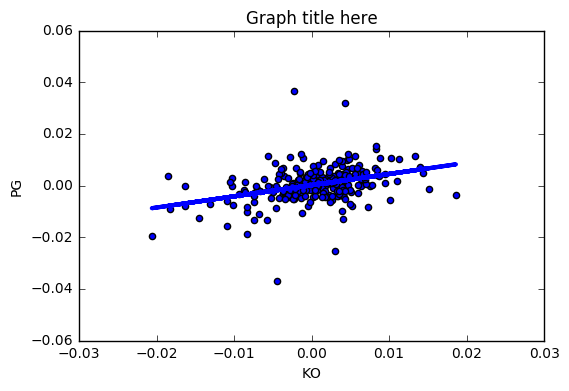

In [31]:
plt.scatter(X, y)
plt.plot(X, lm.predict(X), color='blue', linewidth=3)
plt.xlabel('KO')
plt.ylabel('PG')
plt.title('Graph title here')

Multiple linear regression

In [46]:
lm = LinearRegression()
y = log_returns['EOD-PG'].dropna()
X = log_returns.drop('EOD-PG', axis=1).dropna()
lm.fit(X,y)
print(lm.intercept_)
print(lm.coef_)
print(lm.score(X,y))

5.92797287265e-05
[ 0.10048195 -0.05580727  0.06106727  0.35841036  0.0588026   0.04209415
  0.09133798 -0.06187107 -0.02241071]
0.184457849996


In [48]:
pd.DataFrame(np.array([X.columns,lm.coef_]).T, columns = ['stock', 'coef'])

,stock,coef
0,EOD-MRK,0.100482
1,EOD-GS,-0.0558073
2,EOD-VZ,0.0610673
3,EOD-KO,0.35841
4,EOD-TRV,0.0588026
5,EOD-WMT,0.0420941
6,EOD-V,0.091338
7,EOD-UTX,-0.0618711
8,EOD-UNH,-0.0224107


In [49]:
from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.10f"
      % mean_squared_error(y, lm.predict(X)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, lm.predict(X)))

Coefficients: 
 [ 0.10048195 -0.05580727  0.06106727  0.35841036  0.0588026   0.04209415
  0.09133798 -0.06187107 -0.02241071]
Mean squared error: 0.0000386145
Variance score: 0.18


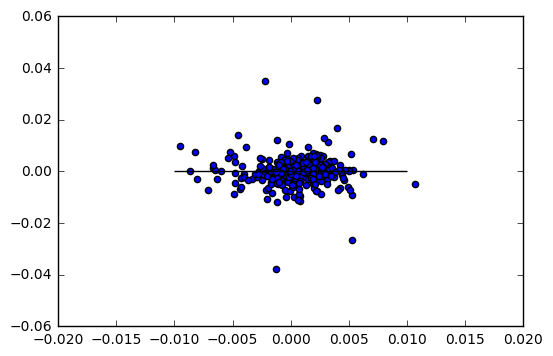

In [50]:
#residual plot
plt.scatter(lm.predict(X), lm.predict(X)-y)
plt.hlines(y=0, xmin=-0.01, xmax=0.01)

In [51]:
#R2 is explained variation / total variation
# heteroscedasticity == non-constant variance of residuals


# p values test null hypothesis. Null hypothesis in that coef=0. 
# A low p-value (< 0.05) indicates that you can reject the null hypothesis - consider removing terms with high P values

#The Durbin-Watson test checks for autocorrelation by looking at he residuals separated by some lag - ranges from 0 to 4
#close to 2 means no autocorrelation

#positive kurtosis - peaked
#negative kurtosis - long tails

#using statsmodels
import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(X) #add a column of 1s
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 EOD-PG   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     6.182
Date:                Thu, 11 Jan 2018   Prob (F-statistic):           7.42e-08
Time:                        23:14:05   Log-Likelihood:                 937.47
No. Observations:                 256   AIC:                            -1855.
Df Residuals:                     246   BIC:                            -1819.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       5.928e-05      0.000      0.145      0.8

Lasso

In [63]:
# Lasso regression

from sklearn.linear_model import Lasso

y = log_returns['EOD-PG'].dropna()
X = log_returns.drop('EOD-PG', axis=1).dropna()

alpha =0.00005

lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
lassoreg.fit(X,y)

Lasso(alpha=5e-05, copy_X=True, fit_intercept=True, max_iter=100000.0,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [64]:
pd.DataFrame(np.array([X.columns,lassoreg.coef_]).T, columns = ['stock', 'coef'])

,stock,coef
0,EOD-MRK,0.0337378
1,EOD-GS,-0
2,EOD-VZ,0.00511084
3,EOD-KO,0.28656
4,EOD-TRV,0
5,EOD-WMT,0
6,EOD-V,0
7,EOD-UTX,-0
8,EOD-UNH,-0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

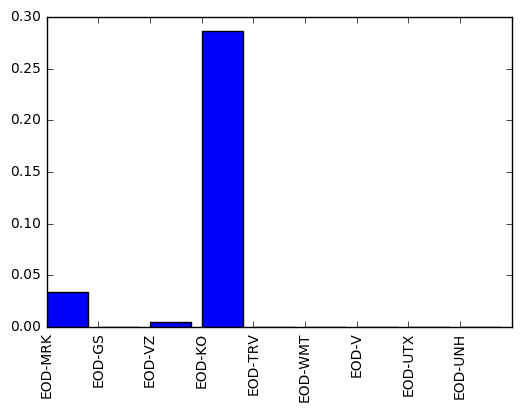

In [65]:
pos=np.arange(len(X.columns))

plt.bar(pos, lassoreg.coef_)
plt.xticks(pos, X.columns)
plt.xticks(rotation=90)

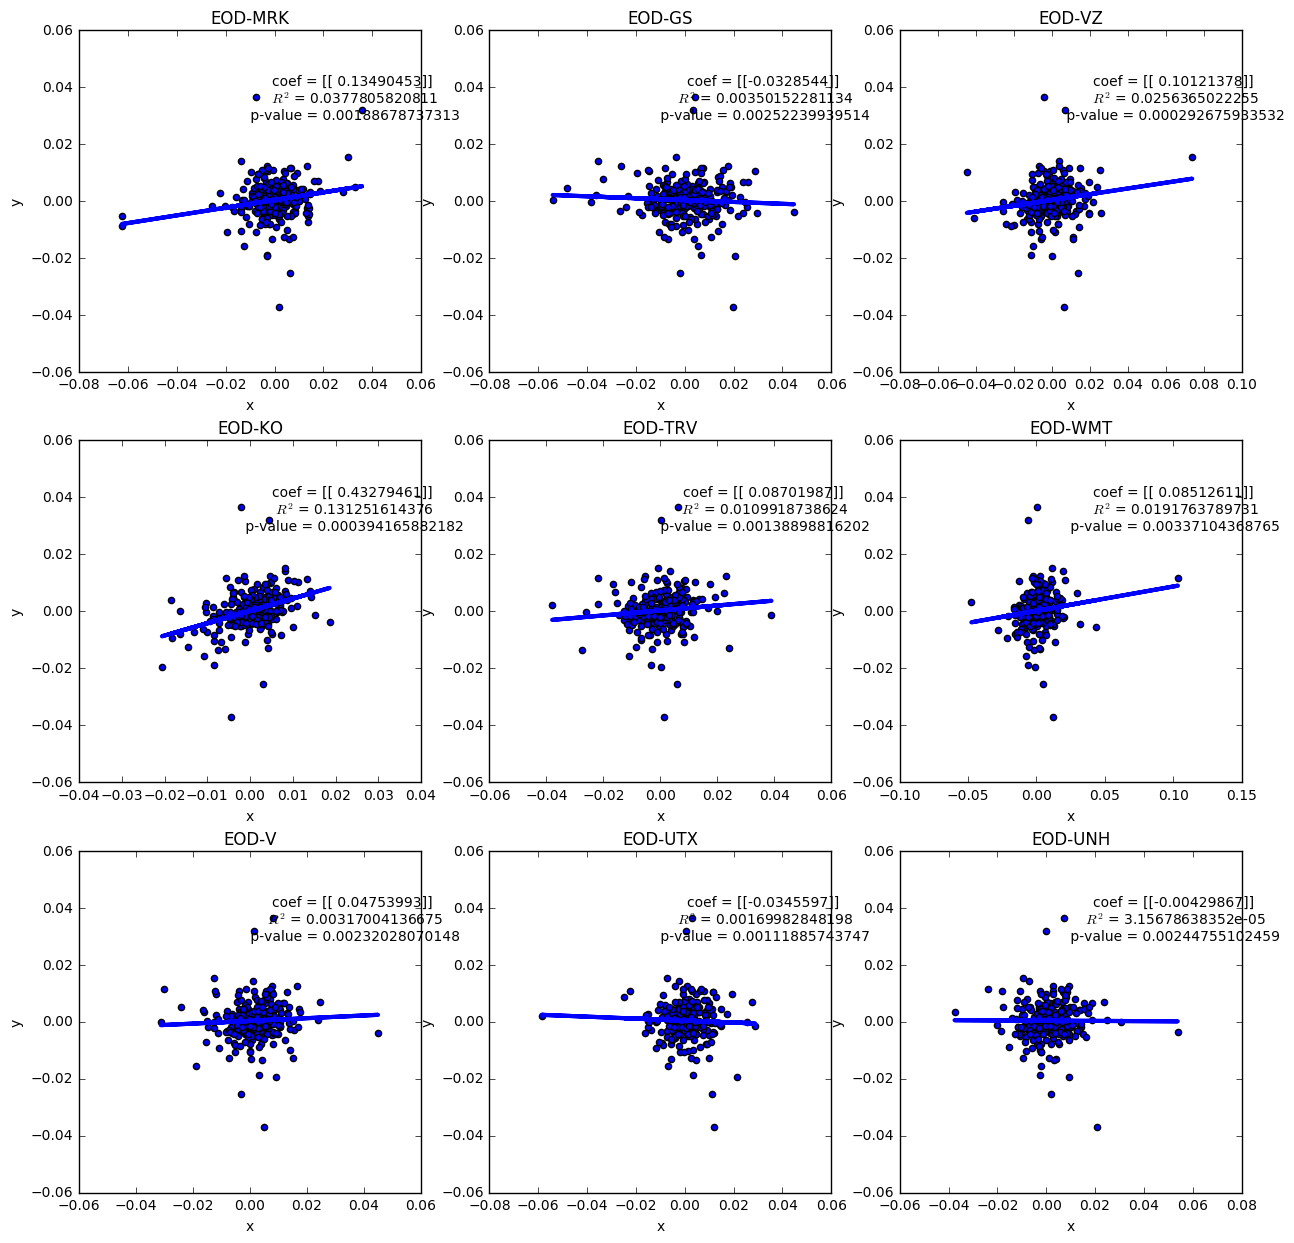

In [67]:
#lots of graphs

lm = LinearRegression()
y = log_returns['EOD-PG'].dropna().to_frame().dropna()

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, figsize=(15,15))



for ax, column in zip(axes.flat, log_returns.drop('EOD-PG', axis=1)):
    X = log_returns[column].dropna().to_frame().dropna()  
    lm.fit(X,y)
    
    ax.scatter(X, y)
    ax.plot(X, lm.predict(X), color='blue', linewidth=3)
    ax.set_title(column)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.text('hi')
    
    #find out why I have this twice
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    pvalue = sm.stats.linear_rainbow(est2)[1]
    
    text(0.8, 0.8,'coef = ' + str(lm.coef_) + '\n $R^{2}$ = ' + str(lm.score(X,y)) + '\n p-value = ' + str(pvalue), ha='center', va='center', transform=ax.transAxes)
    

In [68]:
#scaling for pca

from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(log_returns)
X_std = std_scale.transform(log_returns)

In [69]:
from sklearn.decomposition import PCA
pca = PCA() # PCA(n_components=2)
pca.fit(X_std)

PCA(copy=True, n_components=None, whiten=False)

In [71]:
pca.explained_variance_

array([ 1.98444084,  1.63748411,  1.18290019,  1.10830783,  0.83142984,
        0.80815445,  0.71911975,  0.66840559,  0.60499923,  0.45475817])

<Container object of 10 artists>

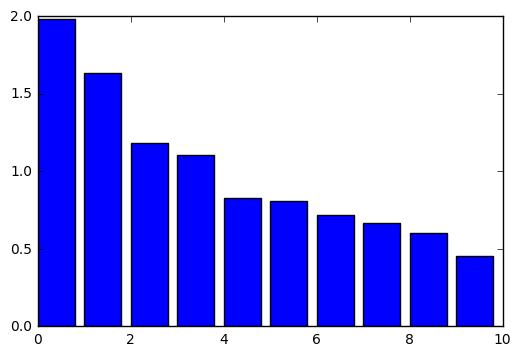

In [74]:
plt.bar(np.arange(len(pca.explained_variance_)), pca.explained_variance_)

In [70]:
pca.components_

array([[ 0.35827982,  0.24224998,  0.41584229,  0.31090998,  0.2234508 ,
         0.34377001,  0.1847241 ,  0.32645259,  0.37808207,  0.30267518],
       [-0.25974641, -0.47044993,  0.31638486, -0.29508935, -0.42421009,
        -0.01062088, -0.23711781,  0.35001057,  0.34771939,  0.21053154],
       [ 0.36675071, -0.30682872,  0.2456457 ,  0.45065328, -0.41865967,
         0.18945266, -0.2263148 , -0.4629486 , -0.0802279 , -0.15740178],
       [-0.20313165,  0.12880409, -0.00787632, -0.19322251,  0.29523984,
         0.6188409 , -0.56515728, -0.10012381,  0.13792579, -0.29354453],
       [ 0.20898178,  0.1650174 ,  0.2580086 , -0.07961164, -0.10716839,
        -0.25243172,  0.03358339,  0.34971863,  0.09692406, -0.8050822 ],
       [-0.3197868 , -0.30284335, -0.07441549,  0.04119215, -0.00200575,
         0.3525264 ,  0.67935397, -0.1871335 ,  0.29600016, -0.30058627],
       [ 0.15863103,  0.03213192, -0.58643911,  0.20961606, -0.07193363,
        -0.22052723, -0.20114672, -0.04240516

In [ ]:
https://www.quantconnect.com/tutorials/introduction-financial-python/
    
    
    
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#LinearModels